In [44]:
from fastai2.vision.all import *
import fastai2

import pdb
import torchvision
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold,StratifiedKFold

In [45]:
import pandas as pd
import numpy as np
import random
import geopandas as gpd
import rasterio
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook as tqdm

def random_seed(seed_value):
    import random 
    random.seed(seed_value) # Python
    import numpy as np
    np.random.seed(seed_value) # cpu vars
    import torch
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [153]:
df = pd.read_csv('Train.csv')

test = pd.read_csv('Test.csv')
test.head(3)
# Sample submission:
ss = pd.read_csv('SampleSubmission.csv')
ss.head(3)

,ID,Label
0,00MZGKU,0
1,015JA41,0
2,01POB64,0


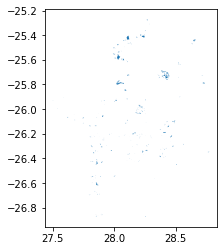

In [47]:
gp = gpd.read_file('GP_Informal_settlement2017.shp')
gp.plot()

In [48]:
from shapely.geometry import Polygon, Point
# lats = []
# lons = []
# labels = []
# for i in tqdm(range(300000)):
#     lon = 28 + random.random()*0.5
#     lat = -26 + random.random()*0.5
#     p = Point(lon, lat)
#     IN = False
#     for geom in gp.geometry:
#         if p.within(geom):
#             IN = True
#     lats.append(lat)
#     lons.append(lon)
#     labels.append(IN)
# ls = pd.DataFrame({
#     'LAT':lats,
#     'LON':lons,
#     'Label':labels
# })
# ls.sample(10)

In [49]:
# ls.Label.value_counts()

In [50]:
# l_sample = pd.concat([ls.loc[ls.Label==True], ls.loc[ls.Label==False].sample(frac=0.025)])
# l_sample.plot(kind='scatter', x='LON', y='LAT', c=l_sample['Label'].map(lambda x: (1, 0, 0.5) if x else (0, 0, 0)))

In [51]:
l_sample=pd.read_csv('l_sample3lac_0.025.csv')

In [52]:
df['Label'].value_counts()/df.shape[0]

False    0.744452
True     0.255548
Name: Label, dtype: float64

In [53]:
l_sample.shape

(11072, 3)

In [54]:
l_sample.Label.value_counts()/l_sample.shape[0]

False    0.669075
True     0.330925
Name: Label, dtype: float64

In [55]:
l_sample['ID']='ID'+l_sample.index.astype(str)

In [56]:
df=pd.concat([df,l_sample])
df.shape

(15353, 4)

In [57]:
df.Label.value_counts()

False    10595
True      4758
Name: Label, dtype: int64

In [58]:
dataset = rasterio.open('2528C.tif') 
# Load bands into RAM
red, green, blue = dataset.read(1), dataset.read(2), dataset.read(3)
# Load bands into RAM

# # Let's do 5 points for now - use df.values to do this for the whole dataset
for ID, lat, lon, label in df.sample(2).values:
    
    # Blank image
    im = np.zeros((200,200,3), np.uint8)
    
    # Get pixel coords
    row, col = dataset.index(lon, lat)
    
    # Add image data
    for i, band in enumerate([red, green, blue]):
        im[:,:,i] = band[row-100:row+100, col-100:col+100]
    
    # Save with the location in the name
    im = Image.fromarray(im)
    pth = 'small_images/negative/'
    if label == True:
        pth = 'small_images/positive/'
    im.save(pth+f"im_{ID}_{lat}_{lon}.jpeg")

In [59]:
bad_IDs = []
for i,x in df.iterrows():
    row, col = dataset.index(x['LON'],x['LAT'])
    if band[row-100:row+100, col-100:col+100].shape != (200,200):
#         print(lon,lat)
        bad_IDs.append(x['ID'])

In [60]:
df = df[~df['ID'].isin(list(set(bad_IDs)))]

In [61]:
df['Label'].value_counts()

False    10495
True      4746
Name: Label, dtype: int64

In [145]:
# Get the image:
random_seed(42)
def get_x(ID):
    row = df.loc[df.ID == ID]
    lat, lon = row['LAT'].values[0], row['LON'].values[0]
    im = np.zeros((200,200,3), np.uint8)
    row, col = dataset.index(lon, lat)
    for i, band in enumerate([red, green, blue]):
        im[:,:,i] = band[row-100:row+100, col-100:col+100]
    
    return im

# And the label
def get_y(ID):
    row = df.loc[df.ID == ID]
    return int(row['Label'].values[0])

# Get the list of Image IDS:
def get_im_ids(path):
    return df.ID.values


def get_data(fold_id,folds,size,bs):
# test_img = ImageList.from_df(test_df, path=data_folder, folder='images')
#     tfms = [Rotate(4),Flip(),Brightness(0.5,p=0.25),Zoom(max_zoom=1.1,p=0.25)]
    tfms = [Rotate(4),Brightness(1.3)]
    # And build the datablock
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_im_ids,
        get_x=get_x,
        get_y=get_y, 
        splitter=KFSplitter(fold_id=fold_id,folds=folds),
        batch_tfms=tfms,
        item_tfms=[Resize(size)]
    )
    dls = dblock.dataloaders(Path(''), bs=bs)
    return dls


In [154]:
random_seed(42)
path = Path('./small_images/')
bs = 64
kf = 10
kfold = StratifiedKFold(n_splits=kf, shuffle=True, random_state=42)
folds = list(kfold.split(X=[x for x in df['ID']],y=df['Label']))
len(folds)
# folds

2

In [155]:
def KFSplitter(fold_id,folds,**kwargs):
    def _inner(o,**kwargs):
        return folds[fold_id]

In [156]:
random_seed(42)
dls = get_data(fold_id=0,folds=folds,size=200,bs=16)

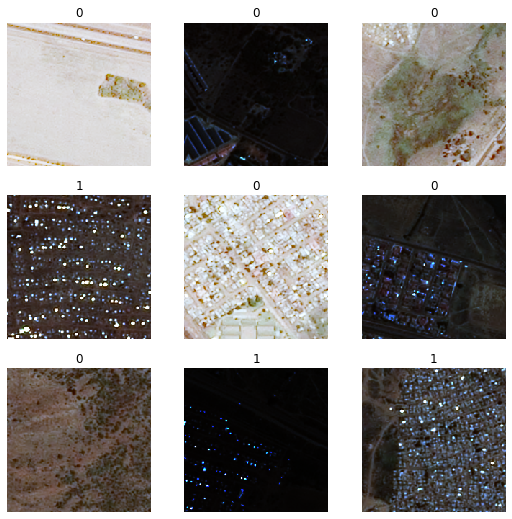

In [158]:
random_seed(42)
dls.show_batch()

In [159]:
random_seed(42)
dls = get_data(fold_id=1,folds=folds,size=200,bs=16)

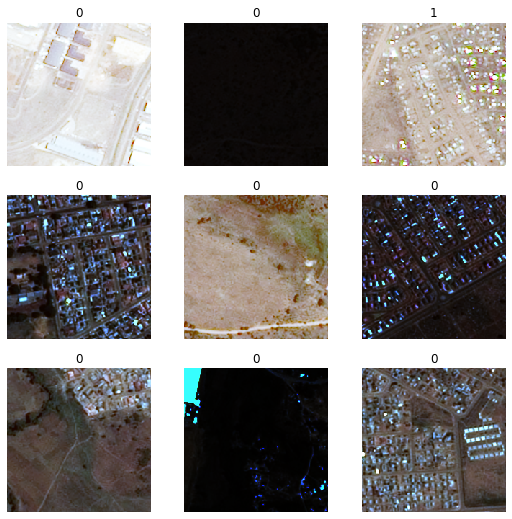

In [160]:
random_seed(42)
dls.show_batch()

In [151]:

for fold_id in range(kf):
    random_seed(42)
#     print(f'Running Fold-{fold_id}')
    dls = dls = get_data(fold_id=fold_id,folds=folds,size=200,bs=16)
    learn = cnn_learner(dls, densenet121, metrics=[error_rate,accuracy])
    learn.fine_tune(1)
    learn.save(f'model-{fold_id}')

Running Fold-0


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.408900,0.172806,0.066929,0.933071,02:21


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.208041,0.074850,0.024934,0.975066,02:32


Running Fold-1


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.408900,0.172806,0.066929,0.933071,01:37


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.208041,0.074850,0.024934,0.975066,02:20


In [31]:
test = pd.read_csv('Test.csv')
test.head(3)

,ID,LAT,LON
0,00MZGKU,-29.8920,30.8575
1,015JA41,-29.8905,30.8705
2,01POB64,-29.9615,30.8950


In [32]:
dataset = rasterio.open('2930D.tif') # We'll use rasterio for all raster operations

In [33]:
red, green, blue = dataset.read(1), dataset.read(2), dataset.read(3)

In [34]:
test['Label']=0
df=pd.concat([df,test])

In [35]:
random_seed(42)
idx = test['ID'].values
tdl = learn.dls.test_dl(idx)

In [36]:
# tdl = learn.dls.test_dl(idx)


In [37]:

def get_k_fold_preds(kf):
    random_seed(42)
    preds = []
    for fold_id in tqdm(range(kf)):
        learn.load(f'model-{fold_id}')
        test_preds = array(learn.get_preds(dl=tdl)[0][:,1])
        preds.append(test_preds)
        
    return preds

In [38]:
ttapreds = get_k_fold_preds(kf)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


preds = get_k_fold_preds(kf)

In [39]:
np.mean(ttapreds,0)

array([0.0027741 , 0.04623529, 0.0510167 , ..., 0.74705136, 0.06527437,
       0.00101117], dtype=float32)

In [40]:
test['Label']=np.mean(ttapreds,0)
test

,ID,LAT,LON,Label
0,00MZGKU,-29.8920,30.8575,0.002774
1,015JA41,-29.8905,30.8705,0.046235
2,01POB64,-29.9615,30.8950,0.051017
3,02125F8,-29.9660,30.8500,0.039436
4,03E8VFF,-29.9080,30.8760,0.015611
...,...,...,...,...
2608,ZXTOTE4,-29.9390,30.8770,0.008975
2609,ZZ37046,-29.9675,30.8730,0.143608
2610,ZZKO0HF,-29.9755,30.9050,0.747051
2611,ZZQN3L6,-29.9115,30.8625,0.065274


In [41]:
sum(test['Label']>0.5)

312

In [42]:
test[['ID','Label']].to_csv('Sub_kf10_dense_bs16_3lac.csv',index=False)

In [43]:
test['Label'].describe()

count    2613.000000
mean        0.168904
std         0.231911
min         0.000016
25%         0.012195
50%         0.060105
75%         0.232104
max         0.997382
Name: Label, dtype: float64

In [37]:
# test['Label']=np.clip(np.mean(preds,0),a_min=0.084386,a_max=1)

In [38]:
# test[['ID','Label']].to_csv('Zindi_sub_20_kf10_clip.csv',index=False)